# Introduction

## AURORA-XCon Experiment: Understanding (PGA-)AURORA Variants

This notebook explores different variants of the AURORA framework:

- **AURORA**: Standard unsupervised feature learning for optimization.
- **AURORA-X**: Incorporates extinction events to promote evolvability.
- **AURORA-Con**: Uses contrastive learning for better latent space organization.
- **AURORA-XCon**: Combines extinction events and contrastive learning.

We will compare their exploration strategies and best-performing policies.

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'

import functools
import logging
import time
from typing import Any

import jax
import jax.numpy as jnp
from omegaconf import OmegaConf

from ae_utils.model_train import init_autoencoder_model_training
from qdax.core.aurora_adaptive import AURORAAdaptivePassive
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.tasks import environments, environments_v1
from qdax.tasks.brax_envs import get_aurora_scoring_fn
from qdax.utils.metrics import passive_qd_metrics
from tasks import task_behavior_descriptor_extractor
from tasks.scoring import scoring_function
from tasks.step import play_step_fn
from utils import (
    get_env,
    get_observation_dims,
    init_population,
)
from viz.visualization import print_trajectory_info
from brax.v1.io import html as html_v1
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Step 1: Configuring and running training for different AURORA variants

Here, we load the config file for our experiment and override default values for our chosen experiment. We also need to override parameters depending on the version of the algorithm that we wish to run. 

- For **AURORA**: set `loss_type="mse"` and `extinction=false`
- For **AURORA-X**: set `loss_type="mse"` and `extinction=true`
- For **AURORA-Con**: set `loss_type="triplet"` and `extinction=false`
- For **AURORA-XCon**: set `loss_type="triplet"` and `extinction=true`

Supported environments are `kheperax`, `brax/half_cheetah`, `brax/ant_maze` and `brax/walker`.

In [2]:
from hydra import compose, initialize

env_name = "brax/ant_maze" # choose from supported environments
loss_type = "mse" # which loss to use for autoencoder
extinction = "false" # whether to use extinction

with initialize(config_path="./configs"):
    cfg = compose(config_name="aurora.yaml", overrides=["env="+env_name, "loss_type="+loss_type, "extinction="+extinction, "num_iterations=50"])

print(OmegaConf.to_yaml(cfg))

/tmp/ipykernel_8536/2197587369.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="./configs"):


wandb:
  project: mt-map-elites
  job_type: train
  name: ${now:%Y_%m_%d_%H_%M_%S}
  mode: online
  group: ${env.name}
  tags:
  - ${name}
  - ${env.name}
env:
  name: ant_maze
  qdax_name: ant_maze
  backend: null
  version: v1
  reward_type: final
  episode_length: 1000
  policy_hidden_layer_size:
  - 128
  - 128
  healthy_z_range:
  - 0.2
  - 5
  exclude_current_positions_from_observation: true
  use_contact_forces: false
  min_bd: -5
  max_bd: 40
  grid_shape:
  - 40
  - 40
  num_init_cvt_samples: 50000
  num_centroids: 1024
  task:
    bd_extractor: xy_pos
    grid_shape:
    - 40
    - 40
    min_bd: -5
    max_bd: 40
    num_init_cvt_samples: 50000
    num_centroids: 1024
    num_descriptors: 2
  vmax: 0
  vmin: -57
  observation_extraction:
    subsample: true
    sampling_freq: 10
    observation_option: sensory_data
    normalize_obs: true
    max_obs_size: 30
name: aurora_baseline
seed: 42
backend: jax
batch_size: 512
num_iterations: 50
num_total_steps: 2000000
metrics_log_p

Initialise the environment, policy, population parameters and initial states of the environment. 

In [3]:
# Init a random key
random_key = jax.random.PRNGKey(cfg.seed)
random_key, subkey = jax.random.split(random_key)

# Init environment
env = get_env(cfg.env)
observations_dims = get_observation_dims(
    cfg,
    env.observation_size,
    (env.aurora_observation_size if cfg.env.name == "kheperax" else None),
)

# Init policy network
policy_layer_sizes = tuple(cfg.env.policy_hidden_layer_size) + (
    env.action_size,
)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(
    jnp.expand_dims(subkey, axis=0), repeats=cfg.batch_size, axis=0
)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

step_fn = functools.partial(
    play_step_fn, policy_network=policy_network, env=env
)

# Init population of controllers
init_variables, random_key = init_population(
    cfg, env, policy_network, random_key
)
params_count = int(
    sum(x.size for x in jax.tree_util.tree_leaves(init_variables))
    / cfg.batch_size
)
logging.info(f"Policy params count (search space): {params_count}")

# Get minimum reward value to make sure qd_score are positive
if cfg.env.name == "kheperax":
    reward_offset = jnp.sqrt(2) * 100
else:
    if cfg.env.version == "v1":
        reward_offset = environments_v1.reward_offset[cfg.env.qdax_name]
    else:
        reward_offset = environments.reward_offset[cfg.env.qdax_name]

Define the scoring function and the way metrics are computed.

In [4]:
# Prepare the scoring function
bd_extraction_fn = functools.partial(
    task_behavior_descriptor_extractor[cfg.env.name]["function"],
    **task_behavior_descriptor_extractor[cfg.env.name]["args"],
)
scoring_fn = functools.partial(
    scoring_function,
    cfg=cfg,
    init_states=init_states,
    play_step_fn=step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

def observation_extractor_fn(
    data,
):
    """Extract observation from the state."""
    data, final_state = data
    if cfg.env.observation_extraction.observation_option == "images":
        observations = final_state.info["image_obs"]

    elif cfg.env.observation_extraction.observation_option == "sensory_data":
        # state_obs: (batch_size, traj_length//sampling_freq, obs_size (max_obs_size))
        observations = data.obs[
            :,
            :: cfg.env.observation_extraction.sampling_freq,
            : cfg.env.observation_extraction.max_obs_size,
        ]
    else:
        raise ValueError("Unknown observation option.")

    return observations

aurora_scoring_fn = get_aurora_scoring_fn(
    scoring_fn=scoring_fn,
    observation_extractor_fn=observation_extractor_fn,
)

# Define a metrics function
metrics_fn = functools.partial(
    passive_qd_metrics,
    qd_offset=(
        reward_offset * cfg.env.episode_length
        if cfg.env.name != "kheperax"
        else reward_offset
    ),
)

Define the emitter used to evolve the population at each mutation step.

In [5]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=cfg.iso_sigma, line_sigma=cfg.line_sigma
)
mixing_emitter = MixingEmitter(
    mutation_fn=lambda x, y: (x, y),
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=cfg.batch_size,
)

Initialise the AutoEncoder used to project high-dimensional observations from evaluation rollouts to low-dimensional latent embeddings. 

In [6]:
# Auto-encoder init
encoder_fn, train_fn, train_state, aurora_extra_info = (
    init_autoencoder_model_training(cfg, observations_dims, random_key)
)

Initialise the AURORA algorithm.

In [7]:
def update_scan_fn(carry: Any, unused: Any) -> Any:
    """Scan the udpate function."""
    (repertoire, passive_repertoire, random_key, aurora_extra_info) = carry

    # update
    (
        repertoire,
        passive_repertoire,
        _,
        metrics,
        random_key,
    ) = aurora.update(
        repertoire,
        passive_repertoire,
        None,
        random_key,
        aurora_extra_info=aurora_extra_info,
    )

    return (
        (repertoire, passive_repertoire, random_key, aurora_extra_info),
        metrics,
    )

# Init algorithm
random_key, subkey = jax.random.split(random_key)
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.state_descriptor_length,
    num_init_cvt_samples=cfg.env.num_init_cvt_samples,
    num_centroids=cfg.env.num_centroids,
    minval=cfg.env.min_bd,
    maxval=cfg.env.max_bd,
    random_key=subkey,
)

# Instantiate AURORA
aurora = AURORAAdaptivePassive(
        scoring_function=aurora_scoring_fn,
        emitter=mixing_emitter,
        metrics_function=metrics_fn,
        encoder_function=encoder_fn,
        training_function=train_fn,
    )
# init step of the aurora algorithm
(
    repertoire,
    passive_repertoire,
    emitter_state,
    aurora_extra_info,
    random_key,
) = aurora.init(
    init_variables,
    centroids,
    aurora_extra_info,
    cfg.max_size,
    random_key,
)

# Init means, stds and AURORA
random_key, subkey = jax.random.split(random_key)
repertoire, train_state, aurora_extra_info, _ = aurora.train(
    repertoire, train_state, random_key=subkey
)

/workspace/src/qdax/core/aurora_adaptive.py:330: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  passive_repertoire, _ = MapElitesRepertoire.init(


Launch a training run for AURORA.

In [8]:
model_params = aurora_extra_info.model_params
previous_error = jnp.sum(repertoire.fitnesses != -jnp.inf) - cfg.target_size
num_generations = cfg.num_iterations // cfg.metrics_log_period
all_metrics = {}
model_metrics = {}
total_evaluations = 0
ae_timelapse = 0
csc_timelapse = 0

# Design AURORA's schedule
default_update_base = cfg.default_update_base
update_base = int(jnp.ceil(default_update_base / cfg.metrics_log_period))
schedules = jnp.cumsum(jnp.arange(update_base, num_generations, update_base))

for i in range(num_generations):

    start_time = time.time()

    (
        (repertoire, passive_repertoire, random_key, aurora_extra_info),
        metrics,
    ) = jax.lax.scan(
        jax.jit(update_scan_fn),
        (repertoire, passive_repertoire, random_key, aurora_extra_info),
        (),
        length=cfg.metrics_log_period,
    )

    timelapse = time.time() - start_time
    del metrics["min_obs"]
    del metrics["max_obs"]

    total_evaluations += cfg.metrics_log_period * cfg.batch_size

    # AE
    if (i + 1) in schedules and not cfg.no_training:
        print("Updating AE...")
        start_time = time.time()
        # train the autoencoder
        random_key, subkey = jax.random.split(random_key)
        repertoire, train_state, aurora_extra_info, model_metrics = aurora.train(
            repertoire, train_state, subkey
        )
        ae_timelapse = time.time() - start_time
        metrics_last_iter = jax.tree_util.tree_map(
            lambda metric: "{0:.4f}".format(float(metric[-1])), model_metrics
        )
        print(metrics_last_iter)

    # Log metrics
    logged_metrics = {
        "time": timelapse + ae_timelapse + csc_timelapse,
        "time_qd": timelapse,
        "time_ae": ae_timelapse,
        "time_csc": csc_timelapse,
        "evaluations": total_evaluations,
        "iteration": 1 + i * cfg.metrics_log_period,
        "env_steps": total_evaluations * cfg.env.episode_length,
    }
    print(
        f"Generation {i + 1}/{num_generations} - Time: {timelapse:.2f} seconds"
    )
    metrics_last_iter = jax.tree_util.tree_map(
        lambda metric: "{0:.2f}".format(float(metric[-1])), metrics
    )
    print(metrics_last_iter)

    if (i + 1) in schedules:
        # Log all AE training metrics
        logged_metrics = {
            **logged_metrics,
            **{key: jnp.mean(value) for key, value in model_metrics.items()},
        }

    # Every n generations, remove all but n% of individuals
    if cfg.extinction:
        if i == num_generations - 1:
            # Don't do an extinction event on the last generation
            pass
        if (i + 1) % cfg.extinction_freq == 0:
            print("Extinction event...")
            random_key, subkey = jax.random.split(random_key)
            repertoire = repertoire.extinction(
                remaining_prop=cfg.remaining_prop, random_key=subkey
            )

Generation 1/10 - Time: 15.12 seconds
{'coverage': '100.00', 'max_fitness': '-29.37', 'passive_coverage': '2.44', 'passive_max_fitness': '-29.37', 'passive_mean_fitness': '-35.19', 'passive_qd_score': '1424120.12', 'qd_score': '58332240.00'}
Updating AE...
{'model_loss': '0.6394', 'recon_loss': '0.6394', 'triplet_loss': '0.0000'}
Generation 2/10 - Time: 14.10 seconds
{'coverage': '100.00', 'max_fitness': '-24.65', 'passive_coverage': '6.25', 'passive_max_fitness': '-24.65', 'passive_mean_fitness': '-33.15', 'passive_qd_score': '3645878.50', 'qd_score': '58332460.00'}
Generation 3/10 - Time: 14.11 seconds
{'coverage': '100.00', 'max_fitness': '-16.61', 'passive_coverage': '10.45', 'passive_max_fitness': '-16.61', 'passive_mean_fitness': '-32.33', 'passive_qd_score': '6095541.00', 'qd_score': '58332848.00'}
Generation 4/10 - Time: 14.30 seconds
{'coverage': '100.00', 'max_fitness': '-16.61', 'passive_coverage': '13.38', 'passive_max_fitness': '-16.61', 'passive_mean_fitness': '-32.08', '

Visualize the final repertoire and the its best policy.

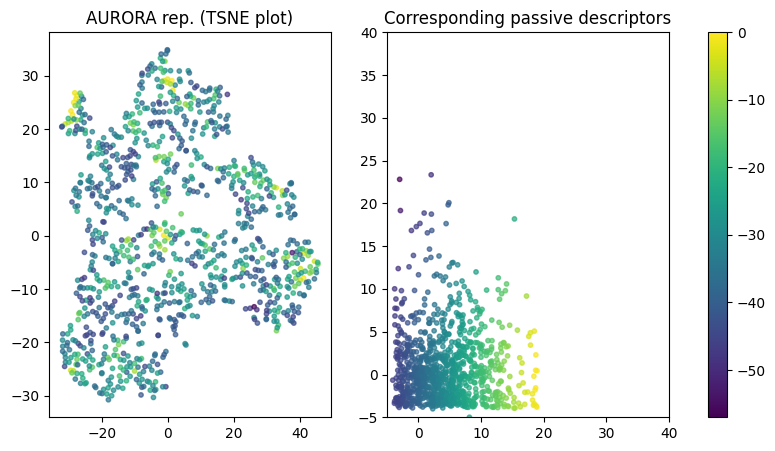

In [9]:
from utils import get_repertoire_fig

fig, axes = get_repertoire_fig(repertoire, cfg, repertoire_name="repertoire")

In [15]:
# Get the best individual of the repertoire
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_bd = repertoire.descriptors[best_idx]
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Behavior descriptor of the best individual in the repertoire: {best_bd}\n",
    f"Index in the repertoire of this individual: {best_idx}\n",
)
params = jax.tree_util.tree_map(lambda x: x[best_idx], repertoire.genotypes)

# Play some steps in the environment
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(policy_network.apply)

if cfg.env.name == "kheperax":
    rollout = []
    s_rollout = []
    rng = jax.random.PRNGKey(seed=1)
    state = jit_env_reset(rng=rng)
    reward = 0
    base_image = env.create_image(state)
    while not state.done:
        image = env.add_robot(base_image, state)
        image = env.add_lasers(image, state)
        image = env.render_rgb_image(image, flip=True)
        rollout.append(image)
        s_rollout.append(state)

        action = jit_inference_fn(params, state.obs)
        state = jit_env_step(state, action)
        reward += state.reward
else:
    rollout = []
    rng = jax.random.PRNGKey(seed=1)
    state = jit_env_reset(rng=rng)
    reward = 0
    while not state.done:
        rollout.append(state)
        action = jit_inference_fn(params, state.obs)
        state = jit_env_step(state, action)
        reward += state.reward

print_trajectory_info(rollout, bd_extraction_fn)

Best fitness in the repertoire: -16.08
 Behavior descriptor of the best individual in the repertoire: [ 0.5088972   2.2626574  -0.68069834 -1.0600127   0.4151879  -1.0866487
 -1.0777962   0.713212    1.6549116   0.12261546]
 Index in the repertoire of this individual: 0

Fitness: -35.653038024902344
 Number of steps: 1000



In [ ]:
HTML(html_v1.render(env.sys, [s.qp for s in rollout]))

### Step 2: Loading a repertoire with a side-by-side comparison of AURORA and AURORA-Con

Here we display a comparison of the latent space and their corresponding hand-coded features between two previously evolved repertoires. We load two repertoires trained in the Brax Walker environment, one with AURORA (reconstruction objective in the AE training) and the other with AURORA-Con (contrastive objective in the AE training).

In [7]:
sns.set_context("paper", font_scale=4.5)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['xtick.labelsize'] = 38
plt.rcParams['ytick.labelsize'] = 38
plt.rcParams['axes.titlesize'] = 48  # Increased axis title size
plt.rcParams['axes.labelsize'] = 42  # Increased axis label size

dot_size = 150 
plot_pad = 0.05

In [8]:
# Load the descriptors and fitnesses
mse_descriptors = np.load("./example_repertoires/results_mse/repertoire/2025_01_28_17_28_30/descriptors.npy")
triplet_descriptors = np.load("./example_repertoires/results_triplet/repertoire/2025_01_28_18_28_27/descriptors.npy")

mse_fitness = np.load("./example_repertoires/results_mse/repertoire/2025_01_28_17_28_30/fitnesses.npy")
triplet_fitness = np.load("./example_repertoires/results_triplet/repertoire/2025_01_28_18_28_27/fitnesses.npy")

handcoded_mse = np.load("./example_repertoires/results_mse/repertoire/2025_01_28_17_28_30/passive_descriptors.npy")
handcoded_triplet = np.load("./example_repertoires/results_triplet/repertoire/2025_01_28_18_28_27/passive_descriptors.npy")

In [9]:
# Filter out -inf values
mse_valid = mse_fitness != -np.inf
triplet_valid = triplet_fitness != -np.inf

mse_descriptors = mse_descriptors[mse_valid]
mse_fitness = mse_fitness[mse_valid]
handcoded_mse = handcoded_mse[mse_valid]

triplet_descriptors = triplet_descriptors[triplet_valid]
triplet_fitness = triplet_fitness[triplet_valid]
handcoded_triplet = handcoded_triplet[triplet_valid]

# Compute global fitness range
fitness_min = min(np.min(mse_fitness), np.min(triplet_fitness))
fitness_max = max(np.max(mse_fitness), np.max(triplet_fitness))

mse_projected = np.nan_to_num(mse_descriptors)
triplet_projected = np.nan_to_num(triplet_descriptors)

# Hand-coded feature spaces (already 2D)
mse_handcoded = handcoded_mse[:, :2]  # Assuming the file is 2D
triplet_handcoded = handcoded_triplet[:, :2]  # Assuming the file is 2D


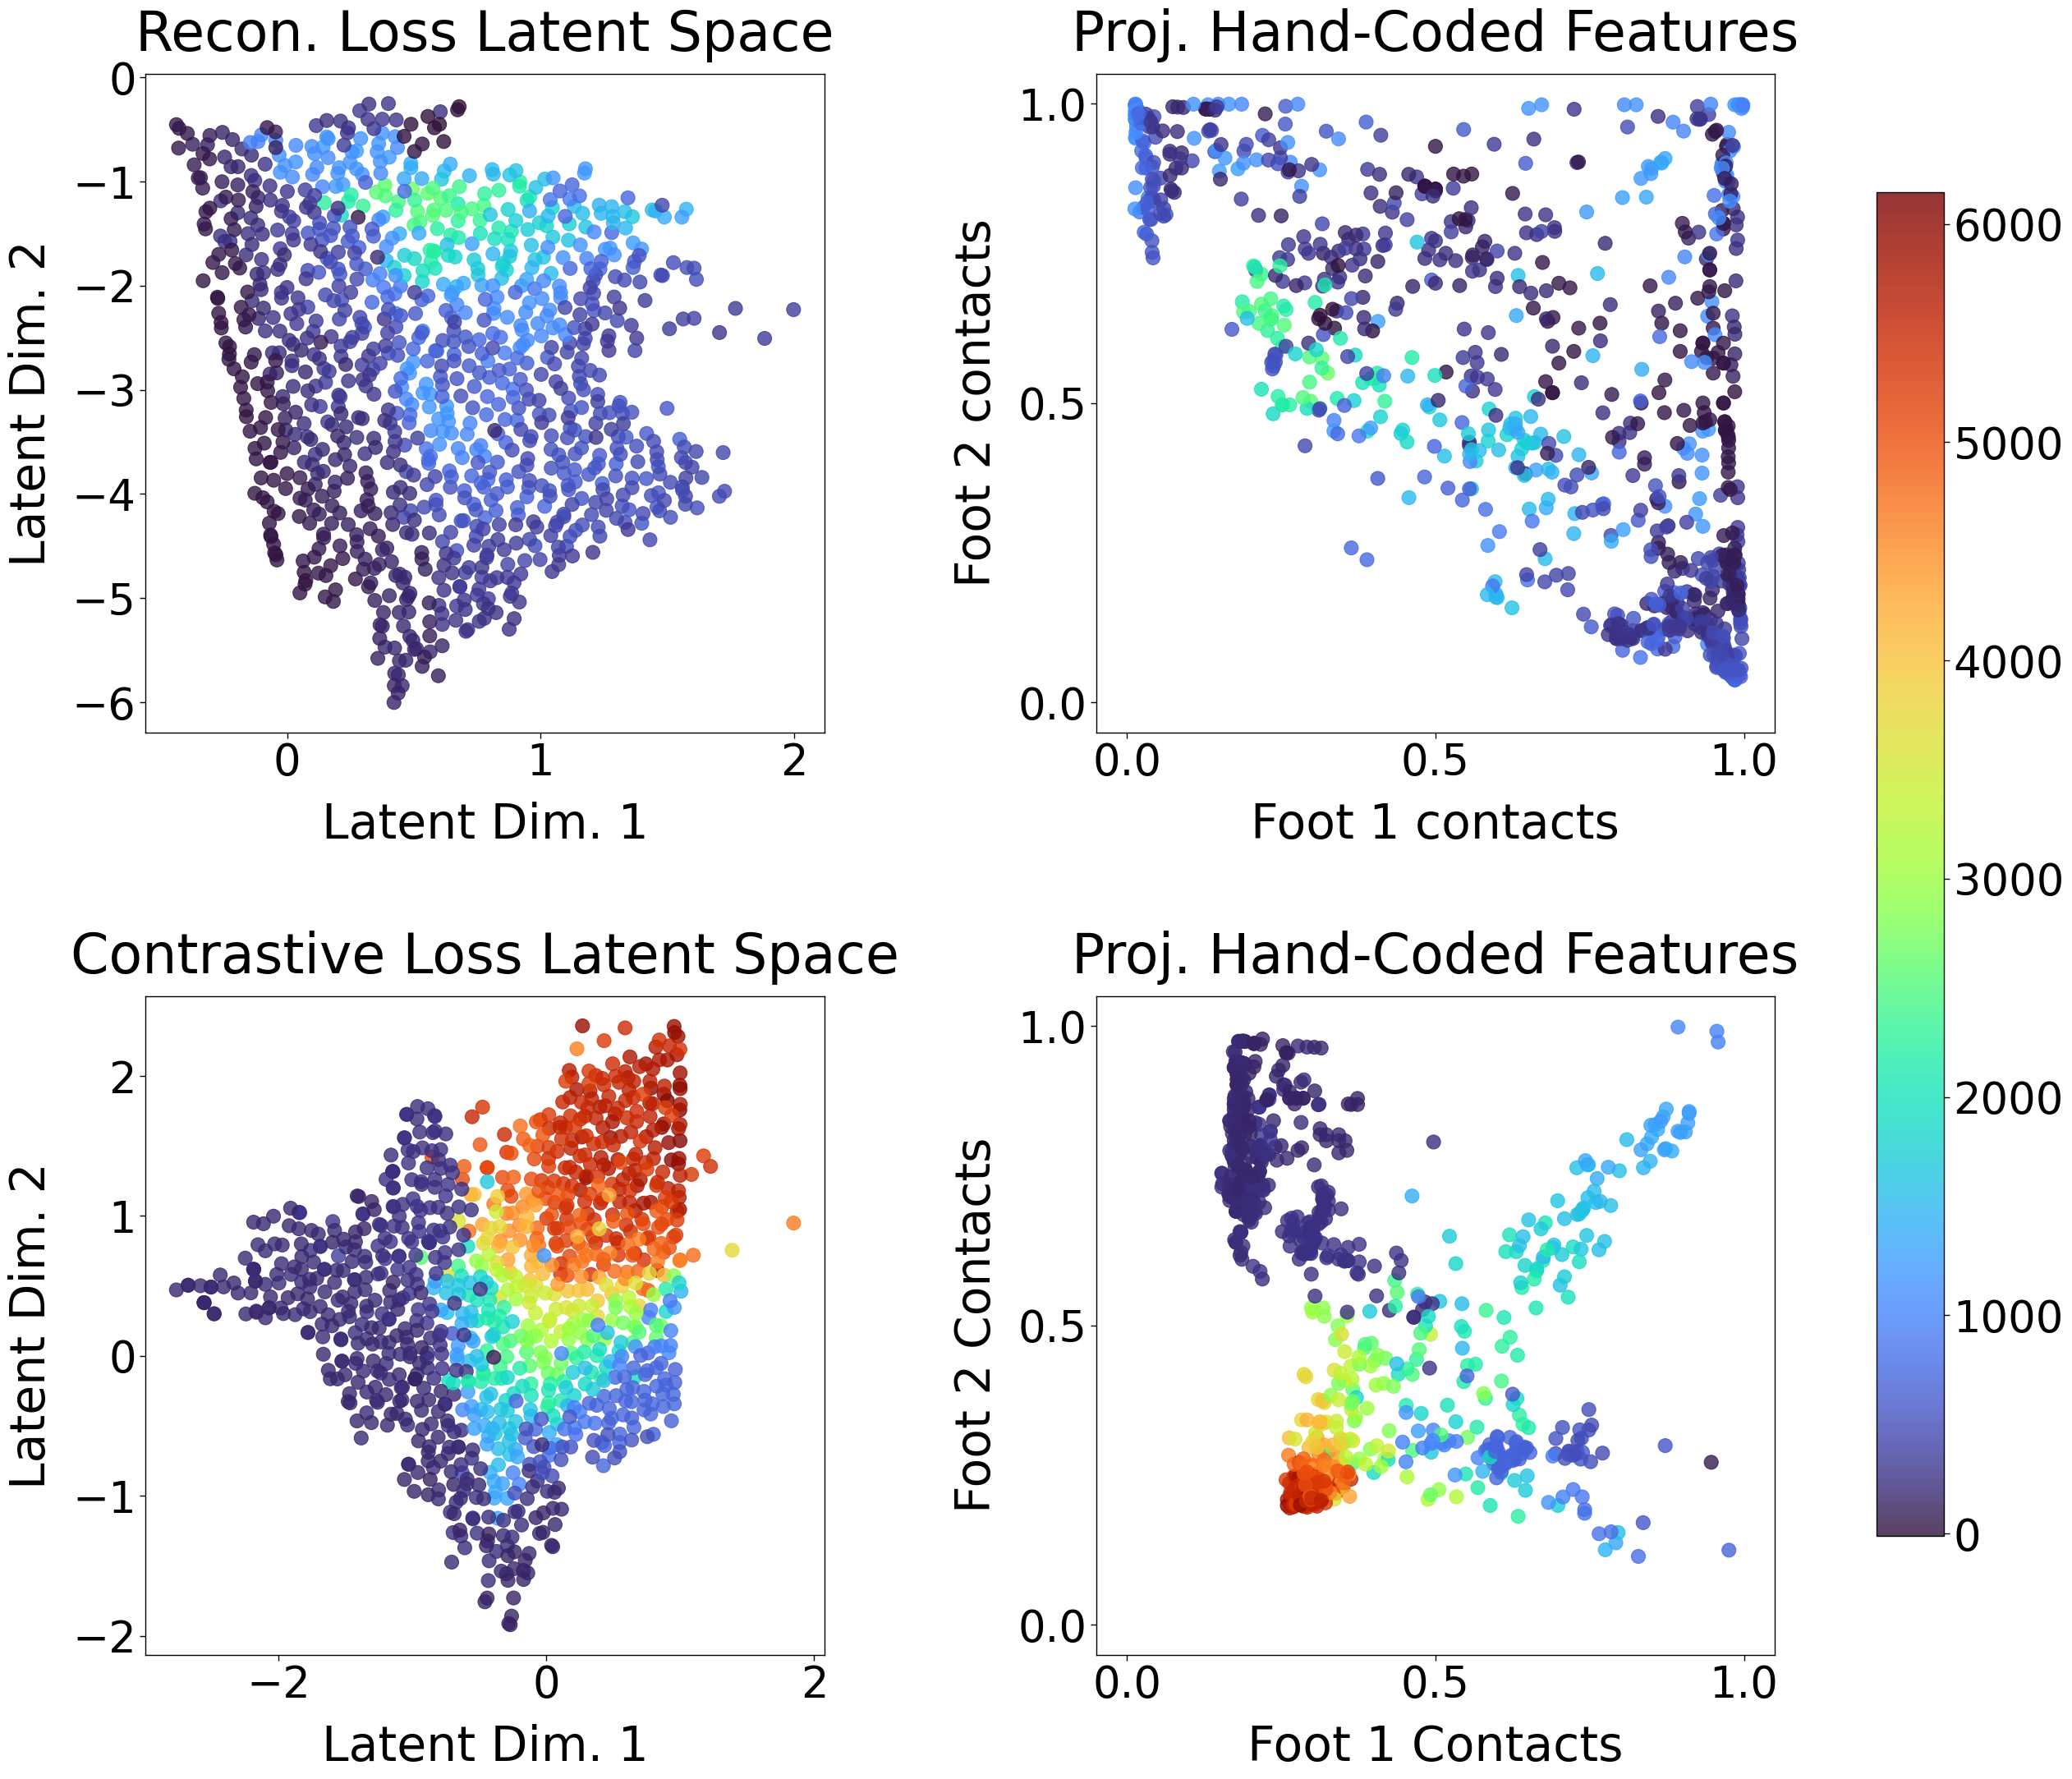

In [10]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(32, 25))  # Increased figure size

# Add more space between subplots to avoid overlap
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Left column: Learned latent spaces
scatter1 = axes[0, 0].scatter(mse_projected[:, 0], mse_projected[:, 1], c=mse_fitness, cmap="turbo", s=dot_size, vmin=fitness_min, vmax=fitness_max, alpha=0.8)
axes[0, 0].set_title("Recon. Loss Latent Space", pad=20)  # Increased padding
axes[0, 0].set_xlabel("Latent Dim. 1", labelpad=15)  # Added padding for x-label
axes[0, 0].set_ylabel("Latent Dim. 2", labelpad=15)  # Added padding for y-label

scatter2 = axes[1, 0].scatter(triplet_projected[:, 0], triplet_projected[:, 1], c=triplet_fitness, cmap="turbo", s=dot_size, vmin=fitness_min, vmax=fitness_max, alpha=0.8)
axes[1, 0].set_title("Contrastive Loss Latent Space", pad=20)
axes[1, 0].set_xlabel("Latent Dim. 1", labelpad=15)
axes[1, 0].set_ylabel("Latent Dim. 2", labelpad=15)

# Right column: Hand-coded feature spaces
scatter3 = axes[0, 1].scatter(mse_handcoded[:, 0], mse_handcoded[:, 1], c=mse_fitness, cmap="turbo", s=dot_size, vmin=fitness_min, vmax=fitness_max, alpha=0.8)
axes[0, 1].set_title("Proj. Hand-Coded Features", pad=20)
axes[0, 1].set_xlim(0.0-plot_pad, 1.0+plot_pad)
axes[0, 1].set_ylim(0.0-plot_pad, 1.0+plot_pad)
axes[0, 1].set_xticks([0.0, 0.5, 1.0])
axes[0, 1].set_yticks([0.0, 0.5, 1.0])
axes[0, 1].set_xlabel("Foot 1 contacts", labelpad=15)
axes[0, 1].set_ylabel("Foot 2 contacts", labelpad=15)

scatter4 = axes[1, 1].scatter(triplet_handcoded[:, 0], triplet_handcoded[:, 1], c=triplet_fitness, cmap="turbo", s=dot_size, vmin=fitness_min, vmax=fitness_max, alpha=0.8)
axes[1, 1].set_title("Proj. Hand-Coded Features", pad=20)
axes[1, 1].set_xlim(0.0-plot_pad, 1.0+plot_pad)
axes[1, 1].set_ylim(0.0-plot_pad, 1.0+plot_pad)
axes[1, 1].set_xticks([0.0, 0.5, 1.0])
axes[1, 1].set_yticks([0.0, 0.5, 1.0])
axes[1, 1].set_xlabel("Foot 1 Contacts", labelpad=15)
axes[1, 1].set_ylabel("Foot 2 Contacts", labelpad=15)

# Shared colorbar
cbar = fig.colorbar(scatter4, ax=axes, location="right", shrink=0.85, pad=0.05)  # Adjusted size and padding

#### Visualize the best policy for AURORA with reconstruction objective

In [ ]:
html_path = "./example_repertoires/results_mse/best_individual/2025_01_28_17_28_30.html"
with open(html_path, "r", encoding="utf-8") as file:
    display(HTML(file.read()))

#### Visualize the best policy for AURORA with contrastive learning objective

In [14]:
html_path = "./example_repertoires/results_triplet/best_individual/2025_01_28_18_28_27.html"
with open(html_path, "r", encoding="utf-8") as file:
    display(HTML(file.read()))